# Objective:
Transfer GPT2 model weights downloaded into our GPTModel instance
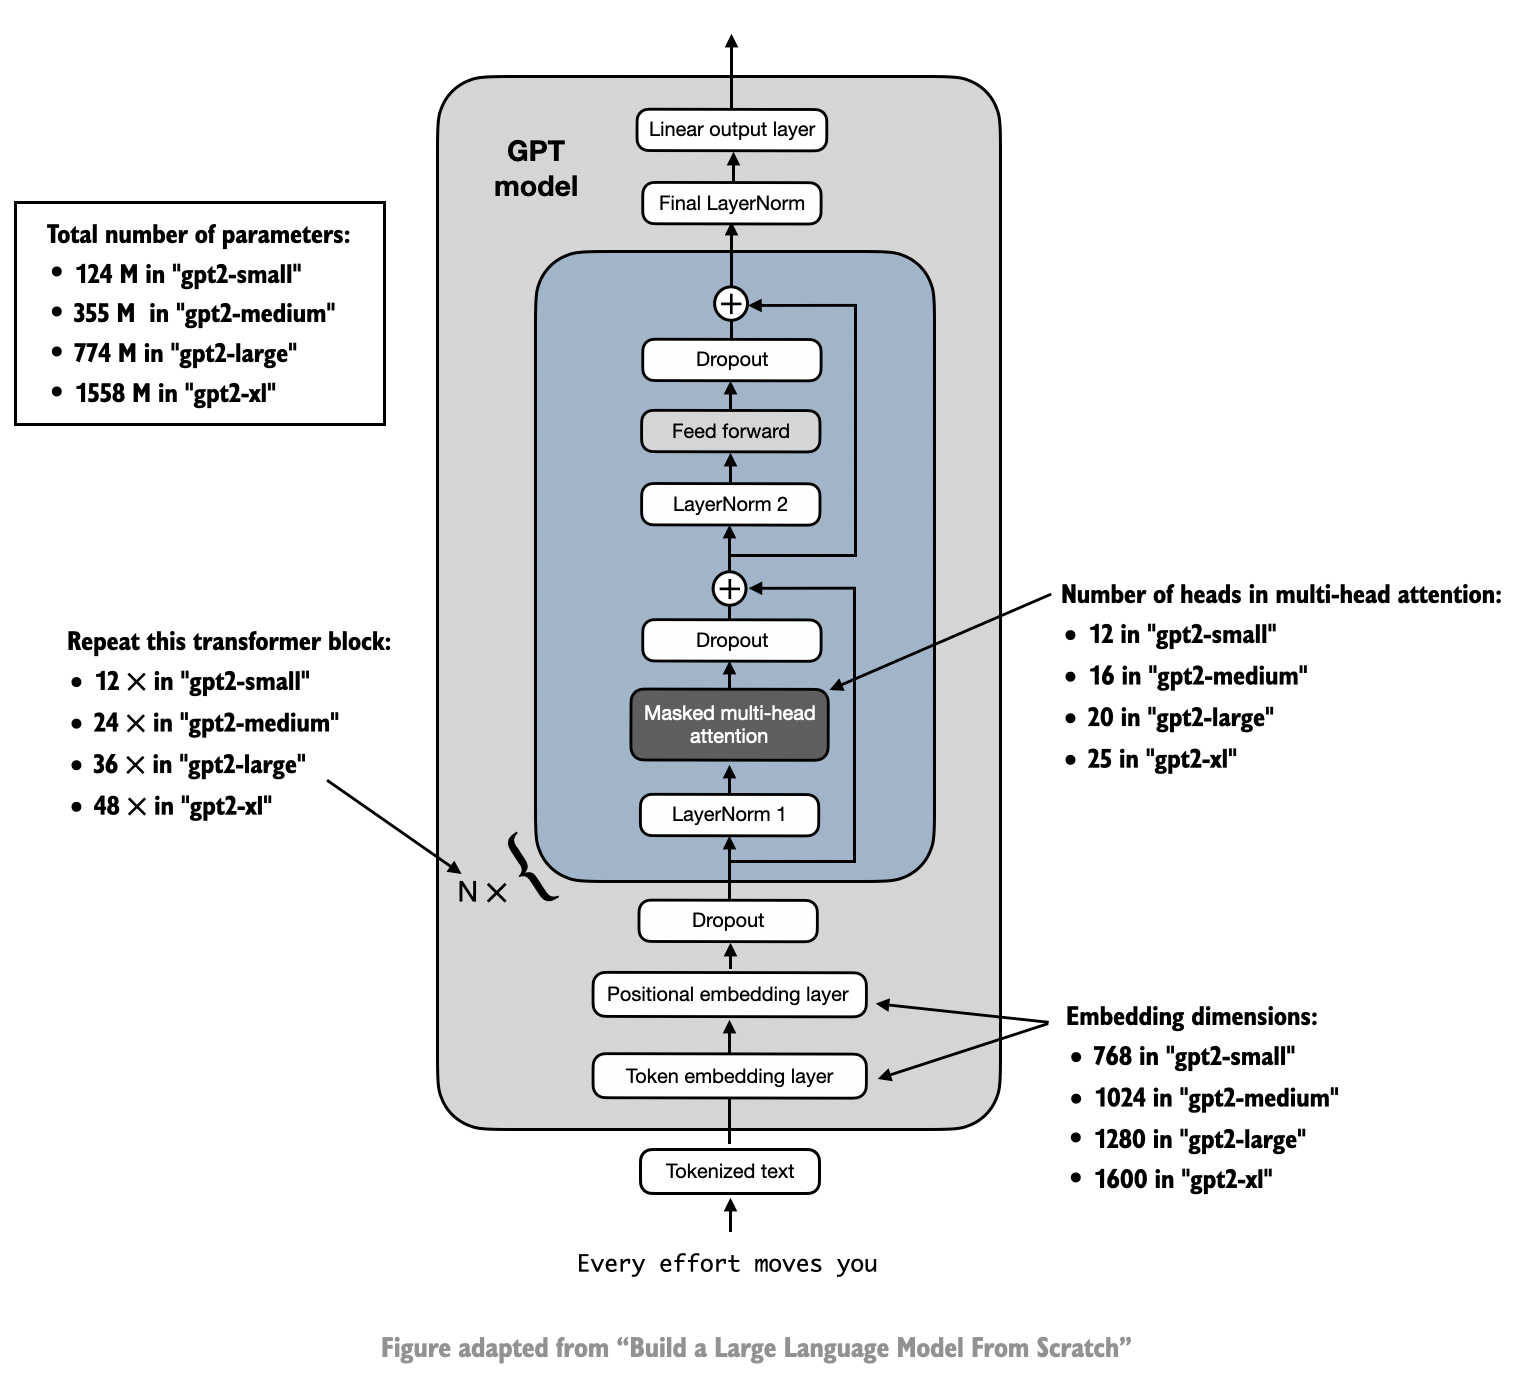

In [2]:
# Update sys path for imports to work
import sys
# print(f"Before: {"\n".join(sys.path)}")  ## Optional print to check
sys.path.append("../../../LLMFromScratch")
# print(f"After: {"\n".join(sys.path)}")  ## Optional print to check

## 1. Recreating GPT Download from previous notebook

In [3]:
from M3_weightloading.gpt_download import download_and_load_gpt2_params

In [4]:
model_size = "124M"
destination_dir = "intermediates/gpt2"

In [5]:
gpt2_settings, gpt2_params = download_and_load_gpt2_params(model_size, destination_dir)

File already exists and is up-to-date: intermediates/gpt2/124M/checkpoint
File already exists and is up-to-date: intermediates/gpt2/124M/encoder.json
File already exists and is up-to-date: intermediates/gpt2/124M/hparams.json
File already exists and is up-to-date: intermediates/gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: intermediates/gpt2/124M/model.ckpt.index
File already exists and is up-to-date: intermediates/gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: intermediates/gpt2/124M/vocab.bpe


In [6]:
gpt2_settings, gpt2_params.keys()

({'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12},
 dict_keys(['blocks', 'b', 'g', 'wpe', 'wte']))

## 2. Load our GPTModel and config

### 2.1 Load and update config to GPT2-124M

In [7]:
from M1_simple_gpt_model.config import TRIAL_CONFIG_PARAMS

In [8]:
TRIAL_CONFIG_PARAMS  # Reference

{'context_length': 9,
 'drop_rate': 0.0,
 'emb_dim': 10,
 'n_heads': 2,
 'n_layers': 3,
 'qvbias': False,
 'vocab_size': 50257}

In [15]:
GPT2_124M_PARAMS = {
    "context_length": gpt2_settings["n_ctx"],  # Using from Original GPT2 Model Settings
    "drop_rate": 0.1,
    "emb_dim": gpt2_settings["n_embd"],  # Using from Original GPT2 Model Settings
    "n_heads": gpt2_settings["n_head"],  # Using from Original GPT2 Model Settings
    "n_layers": gpt2_settings["n_layer"],  # Using from Original GPT2 Model Settings
    "qvbias": True,  # Note that the original GPT model initialized the linear layers for the query, key, and value matrices in the multi-head attention module with bias vectors, which is not required or recommended; however, to be able to load the weights correctly, we have to enable these too by setting qkv_bias to True in our implementation, too
    "vocab_size": gpt2_settings["n_vocab"]  # Using from Original GPT2 Model Settings
    }

### 2.2 Load Model

In [16]:
from M1_simple_gpt_model.trial_gpt_model import TrialGPTModel

In [17]:
gpt2_124m_model = TrialGPTModel(GPT2_124M_PARAMS)
gpt2_124m_model.eval()

TrialGPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (norm_1): LayerNorm()
      (multi_head_attention): MultiHeadAttention(
        (linear_query): Linear(in_features=768, out_features=768, bias=True)
        (linear_key): Linear(in_features=768, out_features=768, bias=True)
        (linear_value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj_linear): Linear(in_features=768, out_features=768, bias=True)
      )
      (drop_out): Dropout(p=0.1, inplace=False)
      (norm_2): LayerNorm()
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (norm_1

In [34]:
parameters_dict = gpt2_124m_model.state_dict()
print(parameters_dict.keys())
print(len(parameters_dict.keys()))

odict_keys(['tok_emb.weight', 'pos_emb.weight', 'transformer_blocks.0.norm_1.scale', 'transformer_blocks.0.norm_1.shift', 'transformer_blocks.0.multi_head_attention.mask', 'transformer_blocks.0.multi_head_attention.linear_query.weight', 'transformer_blocks.0.multi_head_attention.linear_query.bias', 'transformer_blocks.0.multi_head_attention.linear_key.weight', 'transformer_blocks.0.multi_head_attention.linear_key.bias', 'transformer_blocks.0.multi_head_attention.linear_value.weight', 'transformer_blocks.0.multi_head_attention.linear_value.bias', 'transformer_blocks.0.multi_head_attention.out_proj_linear.weight', 'transformer_blocks.0.multi_head_attention.out_proj_linear.bias', 'transformer_blocks.0.norm_2.scale', 'transformer_blocks.0.norm_2.shift', 'transformer_blocks.0.feed_forward.layers.0.weight', 'transformer_blocks.0.feed_forward.layers.0.bias', 'transformer_blocks.0.feed_forward.layers.2.weight', 'transformer_blocks.0.feed_forward.layers.2.bias', 'transformer_blocks.1.norm_1.sca

## 3. Assign OpenAI weights to the corresponding weight tensors in our GPTModel instance

Following parameters are to be Initialised in our model 
= 210 parameters

* (1) tok_emb.weight
* (1) pos_emb.weight
* (12* 17 = 204) For 12 Transformer blocks:
    * (2) norm_1
        * scale
        * shift
    * (9) multi_head_attention
        * (1) mask
        * (2) linear_query
            * weight
            * bias
        * (2) linear_key
            * weight
            * bias
        * (2) linear_value
            * weight
            * bias
        * (2) out_proj_linear
            * weight
            * bias
    * (2) norm_2
        * scale
        * shift
    * (4) feed_forward
        * (2) layers.0 (Linear Layer-1 - Pre-GeLU)
            * weight
            * bias
        * (2) layers.2 (Linear Layer-2 - Post-GeLU)
            * weight
            * bias
* (2) final_norm
    * scale
    * shift
* (2) linear_out
    * weight
    * bias

In [27]:
import torch

### 3.1. Sample load of "pos_emb.weight"

In [31]:
# gpt2_124m_model [pos_emb.weight] = gpt2_params["wpe"]

# Before Assignment
print(f"Before: Weights in our model: {gpt2_124m_model.pos_emb.weight}")

# Checking shape of both sides
print(f"Shape in our model: {gpt2_124m_model.pos_emb.weight.shape}")  # Left
print(f"Shape in original model: {gpt2_params["wpe"].shape}")  # Right

# If shape matches, return torch parameter of right
gpt2_124m_model.pos_emb.weight = torch.nn.Parameter(torch.tensor(gpt2_params["wpe"]))

# After Assignment
print(f"After: Weights in our model: {gpt2_124m_model.pos_emb.weight}")


Before: Weights in our model: Parameter containing:
tensor([[-0.3147, -0.6924,  0.0611,  ..., -0.7039,  0.1026, -0.3878],
        [ 0.8259,  0.2690, -0.0123,  ...,  0.1304,  0.5715, -0.3883],
        [-0.4009,  0.5650,  1.0270,  ...,  0.1711,  0.6593,  0.1286],
        ...,
        [-0.7515,  0.0856,  0.6458,  ...,  0.2031, -1.8471,  1.2055],
        [-1.5283, -0.1350,  0.3501,  ...,  1.8785,  0.0588,  1.4797],
        [ 0.2152,  0.0714,  0.1549,  ..., -1.3661,  0.2659, -2.8281]],
       requires_grad=True)
Shape in our model: torch.Size([1024, 768])
Shape in original model: (1024, 768)
After: Weights in our model: Parameter containing:
tensor([[-1.8821e-02, -1.9742e-01,  4.0267e-03,  ..., -4.3044e-02,
          2.8267e-02,  5.4490e-02],
        [ 2.3959e-02, -5.3792e-02, -9.4879e-02,  ...,  3.4170e-02,
          1.0172e-02, -1.5573e-04],
        [ 4.2161e-03, -8.4764e-02,  5.4515e-02,  ...,  1.9745e-02,
          1.9325e-02, -2.1424e-02],
        ...,
        [-1.7987e-03,  1.6052e-03

### 3.2. Sample load of "tok_emb.weight" using "return_value_to_assign" helper function

In [32]:
from M3_weightloading.manual_load import return_value_to_assign

In [33]:
# gpt2_124m_model [tok_emb.weight] = gpt2_params["wte"]

# Before Assignment
print(f"Before: Weights in our model: {gpt2_124m_model.tok_emb.weight}")

gpt2_124m_model.tok_emb.weight = return_value_to_assign(gpt2_124m_model.tok_emb.weight, gpt2_params["wte"])

# After Assignment
print(f"After: Weights in our model: {gpt2_124m_model.tok_emb.weight}")

Before: Weights in our model: Parameter containing:
tensor([[ 0.6088,  2.2314, -0.5973,  ...,  0.9630,  0.1856,  0.5196],
        [-0.2788, -0.7689,  1.2385,  ...,  0.6917,  0.8827, -0.1333],
        [ 0.7881, -1.5093,  0.7023,  ...,  0.0062,  0.2054,  0.2777],
        ...,
        [ 0.4369,  0.7965,  1.4380,  ..., -0.0333,  0.4029,  1.6490],
        [ 2.4798,  0.1154,  0.4013,  ..., -0.1592,  0.4102, -1.0686],
        [ 0.3527, -0.0412,  0.8628,  ...,  0.0599, -1.2268, -0.8470]],
       requires_grad=True)
After: Weights in our model: Parameter containing:
tensor([[-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
        [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
        [-0.1275,  0.0479,  0.1841,  ...,  0.0899, -0.1297, -0.0879],
        ...,
        [-0.0445, -0.0548,  0.0123,  ...,  0.1044,  0.0978, -0.0695],
        [ 0.1860,  0.0167,  0.0461,  ..., -0.0963,  0.0785, -0.0225],
        [ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207]],
  

### 3.3. Assignment of a transformer block
17 Parameters
* (2) norm_1
    * scale
    * shift
* (9) multi_head_attention
    * (1) mask
    * (2) linear_query
        * weight
        * bias
    * (2) linear_key
        * weight
        * bias
    * (2) linear_value
        * weight
        * bias
    * (2) out_proj_linear
        * weight
        * bias
* (2) norm_2
    * scale
    * shift
* (4) feed_forward
    * (2) layers.0 (Linear Layer-1 - Pre-GeLU)
        * weight
        * bias
    * (2) layers.2 (Linear Layer-2 - Post-GeLU)
        * weight
        * bias

In [59]:
import numpy as np

In [74]:
layer_number = 0

In [76]:
# Taking out Transformer Block-<layer_number> from params
transformer_block = gpt2_params["blocks"][layer_number]
transformer_block.keys()  # Checking keys in transformer block

# Corresponding model parameters
# parameters_dict["transformer_blocks.0...."]

dict_keys(['attn', 'ln_1', 'ln_2', 'mlp'])

#### 3.3.1. Norm 1

In [128]:
norm1 = transformer_block["ln_1"]
norm1.keys()  # Checking keys in transformer norm1 block

dict_keys(['b', 'g'])

In [131]:
print(f"Incoming Params shape: {norm1["g"].shape}")
print(f"Our model Params shape: {parameters_dict["transformer_blocks.0.norm_1.scale"].shape}")

Incoming Params shape: (768,)
Our model Params shape: torch.Size([768])


In [132]:
# Assignment - Norm1 - Scale

# Before Assignment
print(f"Before: Weights in our model: {gpt2_124m_model.transformer_blocks[layer_number].norm_1.scale}")

gpt2_124m_model.transformer_blocks[layer_number].norm_1.scale = return_value_to_assign(gpt2_124m_model.transformer_blocks[layer_number].norm_1.scale, norm1["g"])

# After Assignment
print(f"After: Weights in our model: {gpt2_124m_model.transformer_blocks[layer_number].norm_1.scale}")


Before: Weights in our model: Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

In [126]:
# Repeat for Shift

#### 3.3.2.  Multi Head Attention

In [111]:
mha = transformer_block["attn"]
mha.keys()

dict_keys(['c_attn', 'c_proj'])

##### 3.3.2.0 Mask
No Change

##### 3.3.2.1 Linear QKV Weights

In [112]:
print(f"Incoming Params shape: {mha["c_attn"]["w"].shape}")
print(f"Our model Params shape: {parameters_dict["transformer_blocks.0.multi_head_attention.linear_query.weight"].shape}")

Incoming Params shape: (768, 2304)
Our model Params shape: torch.Size([768, 768])


In [113]:
# Splitting the weights into query, key, and value
query_weight, key_weight, value_weight = np.split(mha["c_attn"]["w"], 3, axis=-1)

# Printing the shapes of the split weights - Transposed
# Note: Transposition is required as per directions in https://github.com/rasbt/LLM-workshop-2024/blob/main/05_weightloading/05_part-1.ipynb
print(f"Query weights shape: {query_weight.T.shape}")
print(f"Key weights shape: {key_weight.T.shape}")
print(f"Value weights shape: {value_weight.T.shape}")

Query weights shape: (768, 768)
Key weights shape: (768, 768)
Value weights shape: (768, 768)


In [114]:
# Assignment - Query, Key, Value

# Before Assignment
print(f"Before: Weights in our model: {gpt2_124m_model.transformer_blocks[layer_number].multi_head_attention.linear_query.weight}")
# Same for linear_key and linear_value

gpt2_124m_model.transformer_blocks[layer_number].multi_head_attention.linear_query.weight = return_value_to_assign(gpt2_124m_model.transformer_blocks[layer_number].multi_head_attention.linear_query.weight, query_weight.T)

# After Assignment
print(f"After: Weights in our model: {gpt2_124m_model.transformer_blocks[layer_number].multi_head_attention.linear_query.weight}")


Before: Weights in our model: Parameter containing:
tensor([[-0.4738,  0.0874,  0.0039,  ..., -0.2592,  0.1517, -0.4100],
        [-0.2614,  0.1473,  0.0695,  ..., -0.0164,  0.2170, -0.1924],
        [-0.0978,  0.2387,  0.3668,  ...,  0.1991,  0.1043, -0.2400],
        ...,
        [ 0.3237, -0.0770, -0.1235,  ..., -0.0335,  0.0827,  0.2170],
        [-0.0483, -0.1492, -0.1660,  ...,  0.1455, -0.0533,  0.1470],
        [-0.2235,  0.1507, -0.0480,  ...,  0.0333, -0.0071, -0.0557]],
       requires_grad=True)
After: Weights in our model: Parameter containing:
tensor([[-0.4738,  0.0874,  0.0039,  ..., -0.2592,  0.1517, -0.4100],
        [-0.2614,  0.1473,  0.0695,  ..., -0.0164,  0.2170, -0.1924],
        [-0.0978,  0.2387,  0.3668,  ...,  0.1991,  0.1043, -0.2400],
        ...,
        [ 0.3237, -0.0770, -0.1235,  ..., -0.0335,  0.0827,  0.2170],
        [-0.0483, -0.1492, -0.1660,  ...,  0.1455, -0.0533,  0.1470],
        [-0.2235,  0.1507, -0.0480,  ...,  0.0333, -0.0071, -0.0557]],
  

##### 3.3.1.2 Linear QKV Biases
Same as Weight section above 
But use mha["c_attn"]["**b**"] and transformer_blocks.0.multi_head_attention.linear_query.**bias**

##### 3.3.2.3 Out Proj

In [115]:
print(f"Incoming Params shape: {mha["c_proj"]["w"].shape}")
print(f"Our model Params shape: {parameters_dict["transformer_blocks.0.multi_head_attention.out_proj_linear.weight"].shape}")

Incoming Params shape: (768, 768)
Our model Params shape: torch.Size([768, 768])


In [116]:
# Assignment - Out Proj

# Before Assignment
print(f"Before: Weights in our model: {gpt2_124m_model.transformer_blocks[layer_number].multi_head_attention.out_proj_linear.weight}")
# Same for linear_key and linear_value

gpt2_124m_model.transformer_blocks[layer_number].multi_head_attention.out_proj_linear.weight = return_value_to_assign(gpt2_124m_model.transformer_blocks[layer_number].multi_head_attention.out_proj_linear.weight, mha["c_proj"]["w"].T)

# After Assignment
print(f"After: Weights in our model: {gpt2_124m_model.transformer_blocks[layer_number].multi_head_attention.out_proj_linear.weight}")


Before: Weights in our model: Parameter containing:
tensor([[ 0.3127, -0.2442, -0.4301,  ...,  0.0202,  0.0171, -0.1011],
        [-0.1874, -0.1978,  0.1544,  ...,  0.1984,  0.0252, -0.0735],
        [ 0.0980, -0.1098,  0.0538,  ..., -0.1482, -0.0184, -0.0024],
        ...,
        [-0.0120, -0.0162,  0.0143,  ...,  0.0235, -0.0008,  0.0063],
        [ 0.0094,  0.0250, -0.0181,  ...,  0.0107,  0.0086,  0.0132],
        [-0.0309,  0.0459, -0.0016,  ..., -0.0150,  0.0050, -0.0171]],
       requires_grad=True)
After: Weights in our model: Parameter containing:
tensor([[ 0.3127, -0.2442, -0.4301,  ...,  0.0202,  0.0171, -0.1011],
        [-0.1874, -0.1978,  0.1544,  ...,  0.1984,  0.0252, -0.0735],
        [ 0.0980, -0.1098,  0.0538,  ..., -0.1482, -0.0184, -0.0024],
        ...,
        [-0.0120, -0.0162,  0.0143,  ...,  0.0235, -0.0008,  0.0063],
        [ 0.0094,  0.0250, -0.0181,  ...,  0.0107,  0.0086,  0.0132],
        [-0.0309,  0.0459, -0.0016,  ..., -0.0150,  0.0050, -0.0171]],
  

In [117]:
## Repeat for out_proj_linear Bias

##### 3.3.2.Wrap E2E MHA Assignment Method

In [118]:
def assign_multi_head_attention(model, layer_number, layer_mha_params):
    """
    Inputs: layer_mha_params: gpt2_params["blocks"][layer_number]["attn"]
    To update following model parameters:
    (9) multi_head_attention
    * (1) mask
    * (2) linear_query
        * weight
        * bias
    * (2) linear_key
        * weight
        * bias
    * (2) linear_value
        * weight
        * bias
    * (2) out_proj_linear
        * weight
        * bias
    """
    # 1. Mask - No change


    # 2. QKV
    incoming_qkv = layer_mha_params["c_attn"]
    
    # 2.1. Weights of query, key, value
    print(f"Incoming QKV Params shape: {incoming_qkv["w"].shape}")
    # 2.1.1. Split weights into 3 parts
    query_weight, key_weight, value_weight = np.split(incoming_qkv["w"], 3, axis=-1)
    # 2.1.2. Assign QKV weights to model
    # Note: Transposition is required as per directions in https://github.com/rasbt/LLM-workshop-2024/blob/main/05_weightloading/05_part-1.ipynb
    model.transformer_blocks[layer_number].multi_head_attention.linear_query.weight = return_value_to_assign(
        model.transformer_blocks[layer_number].multi_head_attention.linear_query.weight, query_weight.T)
    model.transformer_blocks[layer_number].multi_head_attention.linear_key.weight = return_value_to_assign(
            model.transformer_blocks[layer_number].multi_head_attention.linear_key.weight, key_weight.T)
    model.transformer_blocks[layer_number].multi_head_attention.linear_value.weight = return_value_to_assign(
            model.transformer_blocks[layer_number].multi_head_attention.linear_value.weight, value_weight.T)
   
    # 2.2. Biases of query, key, value
    # 2.2.1. Split biases into 3 parts
    query_bias, key_bias, value_bias = np.split(incoming_qkv["b"], 3, axis=-1)
    # 2.2.2. Assign QKV biases to model
    model.transformer_blocks[layer_number].multi_head_attention.linear_query.bias = return_value_to_assign(
        model.transformer_blocks[layer_number].multi_head_attention.linear_query.bias, query_bias)
    model.transformer_blocks[layer_number].multi_head_attention.linear_key.bias = return_value_to_assign(
        model.transformer_blocks[layer_number].multi_head_attention.linear_key.bias, key_bias)
    model.transformer_blocks[layer_number].multi_head_attention.linear_value.bias = return_value_to_assign(
        model.transformer_blocks[layer_number].multi_head_attention.linear_value.bias, value_bias)
    

    # 3. out_proj_linear
    incoming_out_proj = layer_mha_params["c_proj"]
    
    # 3.1. Assign out_proj weights to model
    # Note: Transposition is required as per directions in https://github.com/rasbt/LLM-workshop-2024/blob/main/05_weightloading/05_part-1.ipynb
    model.transformer_blocks[layer_number].multi_head_attention.out_proj_linear.weight = return_value_to_assign(
        model.transformer_blocks[layer_number].multi_head_attention.out_proj_linear.weight, incoming_out_proj["w"].T)

    # 3.2. Assign out_proj biases to model
    model.transformer_blocks[layer_number].multi_head_attention.out_proj_linear.bias = return_value_to_assign(
        model.transformer_blocks[layer_number].multi_head_attention.out_proj_linear.bias, incoming_out_proj["b"])

In [119]:
# E2E MHA Assignment Method - Test - Random Spot checks
layer_number = 0

# Before Assignment
print(f"Before: Key Biases in our model: {gpt2_124m_model.transformer_blocks[layer_number].multi_head_attention.linear_key.bias}")
print(f"Before: Value Weights in our model: {gpt2_124m_model.transformer_blocks[layer_number].multi_head_attention.linear_value.weight}")
print(f"Before: Out Proj Weights in our model: {gpt2_124m_model.transformer_blocks[layer_number].multi_head_attention.out_proj_linear.weight}")

assign_multi_head_attention(gpt2_124m_model, layer_number, gpt2_params["blocks"][layer_number]["attn"])

# After Assignment
print(f"After: Key Biases in our model: {gpt2_124m_model.transformer_blocks[layer_number].multi_head_attention.linear_key.bias}")
print(f"After: Value Weights in our model: {gpt2_124m_model.transformer_blocks[layer_number].multi_head_attention.linear_value.weight}")
print(f"After: Out Proj Weights in our model: {gpt2_124m_model.transformer_blocks[layer_number].multi_head_attention.out_proj_linear.weight}")

Before: Key Biases in our model: Parameter containing:
tensor([-1.4611e-01, -6.3202e-02, -4.7258e-02, -9.2682e-02, -8.3484e-02,
        -1.3571e-01, -1.0058e-01, -2.9561e-02, -1.5705e-01, -2.4262e-01,
        -8.1476e-02, -4.8325e-02, -1.6462e-01, -2.6622e-02,  8.5022e-02,
        -1.9151e-01,  2.0220e-01, -2.2727e-02, -8.3964e-02, -9.4136e-02,
         2.5286e-02,  4.8060e-02,  2.2095e-01, -6.1350e-02,  2.3722e-02,
         8.8407e-02, -3.6372e-02,  8.6801e-02, -8.7590e-02,  8.9762e-03,
        -8.8368e-02, -8.4046e-02,  1.6854e-01,  1.4365e-01,  3.5403e-02,
        -9.3681e-02,  3.4466e-02,  1.2833e-02,  3.6465e-02,  8.8829e-03,
         6.5743e-02, -3.1236e-02,  2.4328e-02, -4.4170e-02,  1.4711e-01,
        -8.4549e-03,  1.9139e-02,  6.4082e-02,  2.4521e-02,  3.7683e-02,
         3.4089e-02, -1.9813e-02,  1.2082e-03,  6.8116e-02,  1.5907e-01,
         9.6397e-02,  1.7645e-02, -9.8472e-03,  1.3708e-01, -1.1867e-01,
        -6.2919e-02, -1.3595e-01, -2.4013e-02, -5.2590e-02, -2.1407e-

#### 3.3.3. Norm 2
Same as Norm 1 , Repeat for transformer_block["ln_2"] - Testing below with Method

In [133]:
def assign_norm_2(model, layer_number, layer_norm_params):
        """
        Inputs: layer_norm_params: gpt2_params["blocks"][layer_number]["ln_2"]
        To update following model parameters:
        (2) norm_2
        * weight
        * bias
        """
        # 1. Assign Scale
        model.transformer_blocks[layer_number].norm_2.scale = return_value_to_assign(
            model.transformer_blocks[layer_number].norm_2.scale, layer_norm_params["g"])
        
        # 2. Assign Shift
        model.transformer_blocks[layer_number].norm_2.shift = return_value_to_assign(
            model.transformer_blocks[layer_number].norm_2.shift, layer_norm_params["b"])
        
        print(f"Updated Layer Norm layer 2 {layer_number} with scale and shift from incoming params.")

In [134]:
# E2E Norm 2 Assignment Method - Test
layer_number = 0

# Before Assignment
print(f"Before: Norm2 Scale in our model: {gpt2_124m_model.transformer_blocks[layer_number].norm_2.scale}")
print(f"Before: Norm2 Scale Shape in our model: {gpt2_124m_model.transformer_blocks[layer_number].norm_2.scale.shape}")
print(f"Before: Norm2 Shift in our model: {gpt2_124m_model.transformer_blocks[layer_number].norm_2.shift}")
print(f"Before: Norm2 Shift Shape in our model: {gpt2_124m_model.transformer_blocks[layer_number].norm_2.shift.shape}")

assign_norm_2(gpt2_124m_model, layer_number, gpt2_params["blocks"][layer_number]["ln_2"])

# After Assignment
print(f"After: Norm2 Scale in our model: {gpt2_124m_model.transformer_blocks[layer_number].norm_2.scale}")
print(f"After: Norm2 Scale Shape in our model: {gpt2_124m_model.transformer_blocks[layer_number].norm_2.scale.shape}")
print(f"After: Norm2 Shift in our model: {gpt2_124m_model.transformer_blocks[layer_number].norm_2.shift}")
print(f"After: Norm2 Shift Shape in our model: {gpt2_124m_model.transformer_blocks[layer_number].norm_2.shift.shape}")

Before: Norm2 Scale in our model: Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

#### 3.3.4. Feed Forward
(4) feed_forward
* (2) layers.0 (Linear Layer-1 - Pre-GeLU)
    * weight
    * bias
* (2) layers.2 (Linear Layer-2 - Post-GeLU)
    * weight
    * bias

In [108]:
ff = transformer_block["mlp"]
ff.keys()

dict_keys(['c_fc', 'c_proj'])

##### 3.3.4.1. Linear Layer-1 - Pre-GeLU

In [109]:
print(f"Incoming Params shape: {ff["c_fc"]["w"].shape}")
print(f"Our model Params shape: {parameters_dict["transformer_blocks.0.feed_forward.layers.0.weight"].shape}")

Incoming Params shape: (768, 3072)
Our model Params shape: torch.Size([3072, 768])


In [110]:
# Assignment - Query, Key, Value

# Before Assignment
print(f"Before: Weights in our model: {gpt2_124m_model.transformer_blocks[layer_number].feed_forward.layers[0].weight}")
# Same for linear_key and linear_value

gpt2_124m_model.transformer_blocks[layer_number].feed_forward.layers[0].weight = return_value_to_assign(gpt2_124m_model.transformer_blocks[layer_number].feed_forward.layers[0].weight, ff["c_fc"]["w"].T)

# After Assignment
print(f"After: Weights in our model: {gpt2_124m_model.transformer_blocks[layer_number].feed_forward.layers[0].weight}")

Before: Weights in our model: Parameter containing:
tensor([[ 0.0197,  0.0071, -0.0184,  ..., -0.0192,  0.0097, -0.0022],
        [ 0.0120,  0.0165,  0.0263,  ..., -0.0261,  0.0117, -0.0041],
        [ 0.0040,  0.0079,  0.0234,  ..., -0.0011,  0.0076, -0.0279],
        ...,
        [ 0.0088, -0.0249,  0.0287,  ...,  0.0316, -0.0158,  0.0319],
        [ 0.0279, -0.0340, -0.0205,  ...,  0.0201,  0.0326,  0.0131],
        [ 0.0289, -0.0281, -0.0347,  ...,  0.0058, -0.0076,  0.0215]],
       requires_grad=True)
After: Weights in our model: Parameter containing:
tensor([[ 0.0942, -0.1265,  0.0496,  ...,  0.0480,  0.0324, -0.0316],
        [ 0.0982, -0.0671, -0.0373,  ...,  0.1575,  0.1249,  0.0010],
        [-0.0321,  0.0305, -0.0483,  ...,  0.0014, -0.0426, -0.0491],
        ...,
        [-0.1783,  0.1966,  0.0655,  ..., -0.3987, -0.1934, -0.0406],
        [ 0.1474, -0.1203, -0.0714,  ...,  0.0889,  0.1272,  0.0536],
        [ 0.0706, -0.0628,  0.0826,  ...,  0.0240, -0.0405,  0.1896]],
  

-------- Similarly for Bias (without T) --------

##### 3.3.4.2. Linear Layer-2 - Post-GeLU

---------- Same as c_fc above for c_proj ----------

In [123]:
print(f"Incoming Params shape: {ff["c_proj"]["w"].shape}")
print(f"Our model Params shape: {parameters_dict["transformer_blocks.0.feed_forward.layers.2.weight"].shape}")

Incoming Params shape: (3072, 768)
Our model Params shape: torch.Size([768, 3072])


In [124]:
##### 3.3.4.Wrap E2E FF Assignment Method
def assign_feed_forward(model, layer_number, layer_ff_params):
    """
    Inputs: layer_ff_params: gpt2_params["blocks"][layer_number]["mlp"]
    To update following model parameters:
    (4) feed_forward
    * (2) layers.0 (Linear Layer-1 - Pre-GeLU)
        * weight
        * bias
    * (2) layers.2 (Linear Layer-2 - Post-GeLU)
        * weight
        * bias
    """

    # 1. Linear Layer-1 - Pre-GeLU
    pre_gelu = layer_ff_params["c_fc"]
    
    # 1.1. Assign pre_gelu weights
    print(f"Incoming Pre GELU shape: {pre_gelu['w'].shape}") #  - To Check Uncomment
    # Note: Transposition is required as incoming weights are in shape (emb_dim, 4*emb_dim) and our model requires (4*emb_dim, emb_dim)
    model.transformer_blocks[layer_number].feed_forward.layers[0].weight = return_value_to_assign(
        model.transformer_blocks[layer_number].feed_forward.layers[0].weight, pre_gelu["w"].T)
    
    # 1.2. Assign pre_gelu biases
    model.transformer_blocks[layer_number].feed_forward.layers[0].bias = return_value_to_assign(
        model.transformer_blocks[layer_number].feed_forward.layers[0].bias, pre_gelu["b"])


    # 2. Linear Layer-2 - Post-GeLU
    post_gelu = layer_ff_params["c_proj"]

    # 2.1. Assign post_gelu weights
    print(f"Incoming Post GELU shape: {post_gelu['w'].shape}") #  - To Check Uncomment
    # Note: Transposition is required as incoming weights are in shape (4*emb_dim, 4*emb_dim) and our model requires (emb_dim, emb_dim)
    model.transformer_blocks[layer_number].feed_forward.layers[2].weight = return_value_to_assign(
        model.transformer_blocks[layer_number].feed_forward.layers[2].weight, post_gelu["w"].T)
    
    # 2.2. Assign post_gelu biases
    model.transformer_blocks[layer_number].feed_forward.layers[2].bias = return_value_to_assign(
        model.transformer_blocks[layer_number].feed_forward.layers[2].bias, post_gelu["b"])
    
    print(f"Updated FF layer {layer_number} with weights and biases from incoming params.")

In [125]:
# E2E FF Assignment Method - Test - Random Spot checks
layer_number = 0

# Before Assignment
print(f"Before: Pre-GeLU Biases in our model: {gpt2_124m_model.transformer_blocks[layer_number].feed_forward.layers[0].bias}")
print(f"Before: Pre-GeLU Biases Shape in our model: {gpt2_124m_model.transformer_blocks[layer_number].feed_forward.layers[0].bias.shape}")
print(f"Before: Post-GeLU Weights in our model: {gpt2_124m_model.transformer_blocks[layer_number].feed_forward.layers[2].weight}")
print(f"Before: Post-GeLU Weights Shape in our model: {gpt2_124m_model.transformer_blocks[layer_number].feed_forward.layers[2].weight.shape}")

assign_feed_forward(gpt2_124m_model, layer_number, gpt2_params["blocks"][layer_number]["mlp"])

# After Assignment
print(f"After: Pre-GeLU Biases in our model: {gpt2_124m_model.transformer_blocks[layer_number].feed_forward.layers[0].bias}")
print(f"After: Pre-GeLU Biases Shape in our model: {gpt2_124m_model.transformer_blocks[layer_number].feed_forward.layers[0].bias.shape}")
print(f"After: Post-GeLU Weights in our model: {gpt2_124m_model.transformer_blocks[layer_number].feed_forward.layers[2].weight}")
print(f"After: Post-GeLU Weights Shape in our model: {gpt2_124m_model.transformer_blocks[layer_number].feed_forward.layers[2].weight.shape}")

Before: Pre-GeLU Biases in our model: Parameter containing:
tensor([-0.0145, -0.0089,  0.0108,  ...,  0.0348,  0.0258, -0.0077],
       requires_grad=True)
Before: Pre-GeLU Biases Shape in our model: torch.Size([3072])
Before: Post-GeLU Weights in our model: Parameter containing:
tensor([[-1.0577e-02,  1.0423e-02, -4.6448e-03,  ..., -1.3009e-02,
         -1.5780e-03,  7.8734e-04],
        [-1.6383e-02,  1.0927e-02, -5.8168e-03,  ..., -8.0061e-03,
         -6.6261e-03, -1.6944e-02],
        [-1.7264e-03,  8.1941e-03, -1.4823e-03,  ..., -1.0141e-02,
         -7.2483e-03,  1.7066e-02],
        ...,
        [ 1.0915e-02,  3.0848e-03, -5.3696e-03,  ...,  1.0333e-02,
          1.5413e-02,  4.9742e-03],
        [ 3.9450e-03,  1.1501e-02, -1.3460e-02,  ..., -4.7976e-05,
         -1.0547e-02, -7.8492e-03],
        [-1.6343e-02,  1.5132e-02, -8.4035e-03,  ..., -5.4830e-03,
          1.5177e-02, -9.9703e-03]], requires_grad=True)
Before: Post-GeLU Weights Shape in our model: torch.Size([768, 3072